# Airbnb - Data Preparation and Exploration

**Content of this notebook:**
1. Preparation of the dataset
    - Airbnb dataset
    - Neighbourhoods dataset
    - Metro stations dataset
2. Feature Engineering
3. Data exploration

*For the data modelling, please see the notebook called 'Airbnb - Modelling'.*

## 1. Preparation of the dataset

Importing the libraries used in this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import re
from math import radians, cos, sin, asin, sqrt
import pickle
import geopandas as gpd
from shapely.geometry import Polygon, Point
import shapely.wkt

### 1.1 Airbnb dataset

Reading the data into a Pandas DataFrame and a first exploration of the dataset. The full dataset contains 24.134 rows (properties) and 106 columns.

In [2]:
airbnb_full = pd.read_csv('listings.csv.gz')

C:\Users\Wendy\Anaconda3\envs\env2\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (61,62,94,95) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
airbnb_full.shape

(24134, 106)

In [4]:
for x in airbnb_full.columns:
    print(x)

id
listing_url
scrape_id
last_scraped
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
access
interaction
house_rules
thumbnail_url
medium_url
picture_url
xl_picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_ni

The dataset contains a lot of columns and I won't be using all of them for the purpose of this project. I am mainly interested in the features of the property, and not in the characteristics and qualifications of the host, house rules or reviews. Below I select the columns that I will continue to use.

In [5]:
columns = ['id', 'last_scraped', 'name', 'summary', 'space', 'description', 'transit', 'access', 'street', 'neighbourhood', 
           'city', 'state', 'zipcode', 'market', 'smart_location', 'country', 'latitude', 'longitude', 'is_location_exact',
           'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 
           'square_feet', 'price', 'weekly_price', 'monthly_price', 'cleaning_fee', 'availability_30', 'availability_60', 
           'availability_90', 'availability_365', 'reviews_per_month', 'minimum_nights', 'maximum_nights']

airbnb = airbnb_full[columns].copy()

The price columns are read as text. I remove the dollar signs and commas (thousands separators) from the the prices and after change the datatype to float.

In [6]:
airbnb.loc[:,'last_scraped'] = pd.to_datetime(airbnb.loc[:,'last_scraped'])

airbnb.loc[:,'price'] = airbnb.loc[:,'price'].str.replace('$', '')
airbnb.loc[:,'price'] = airbnb.loc[:,'price'].str.replace(',', '')
airbnb.loc[:,'price'] = airbnb.loc[:,'price'].astype('float64')

airbnb.loc[:,'weekly_price'] = airbnb.loc[:,'weekly_price'].str.replace('$', '')
airbnb.loc[:,'weekly_price'] = airbnb.loc[:,'weekly_price'].str.replace(',', '')
airbnb.loc[:,'weekly_price'] = airbnb.loc[:,'weekly_price'].astype('float64')

airbnb.loc[:,'monthly_price'] = airbnb.loc[:,'monthly_price'].str.replace('$', '')
airbnb.loc[:,'monthly_price'] = airbnb.loc[:,'monthly_price'].str.replace(',', '')
airbnb.loc[:,'monthly_price'] = airbnb.loc[:,'monthly_price'].astype('float64')

airbnb.loc[:,'cleaning_fee'] = airbnb.loc[:,'cleaning_fee'].str.replace('$', '')
airbnb.loc[:,'cleaning_fee'] = airbnb.loc[:,'cleaning_fee'].str.replace(',', '')
airbnb.loc[:,'cleaning_fee'] = airbnb.loc[:,'cleaning_fee'].astype('float64')

In [7]:
airbnb.dtypes

id                            int64
last_scraped         datetime64[ns]
name                         object
summary                      object
space                        object
description                  object
transit                      object
access                       object
street                       object
neighbourhood                object
city                         object
state                        object
zipcode                      object
market                       object
smart_location               object
country                      object
latitude                    float64
longitude                   float64
is_location_exact            object
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
square_feet                 

I drop the rows with Saint Martin as a country instead of Argentina.

In [8]:
airbnb.country.unique()

array(['Argentina', 'Saint Martin'], dtype=object)

In [9]:
airbnb = airbnb.drop(airbnb[airbnb.country == 'Saint Martin'].index)

I will check out the unique values in the city, state, neighbourhood and market columns to make sure that the dataset only contains airbnb listings in the city of Buenos Aires.

In [10]:
airbnb.city.unique()

array(['Buenos Aires', 'Palermo/Buenos Aires', 'Retiro', 'Palermo',
       'Ciudad autónoma de Buenos Aires',
       'Ciudad Autónoma de Buenos Aires', nan, 'CABA ', 'Recoleta',
       'Monserrat', 'Almagro', '1425 Buenos Aires', 'Buenos Aires ',
       'Capital federal', 'Capital Federal', 'Las Canitas, Buenos Aires',
       'Constitución', 'San Nicolas', 'Palermo Soho', 'Palermo Hollywood',
       'Reoleta', 'San Telmo', 'Ciudad de Buenos Aires', 'CF',
       'Colegiales, CABA', 'Buenos aires', 'DRK', 'Buenos Aires. Palermo',
       'CABA', 'ciudad de buenos aires',
       'Ciudad Autonoma de Buenos Aires', 'Buenos Aires - CAPITAL',
       'Recoleta, Buenos Aires', 'Buenos Aires / Puerto Madero',
       'buenos aires', 'Buenos Aires, Argentina',
       'Autonomous City of Buenos Aires', 'Palermo, Buenos Aires',
       'Ciudad Autónoma de Buenos Aires ', 'Centro',
       'ciudad autonoma de buenos aires', 'Buenos Aires - Caballito -',
       'Las Cañitas Palermo', 'San Nicolás',
     

In [11]:
airbnb.state.unique()

array(['Capital Federal', 'Autonomous City of Buenos Aires',
       'Ciudad Autónoma de Buenos Aires', 'Buenos Aires', nan,
       'Ciudad Autonoma de Buenos Aires', 'CABA', 'Palermo', 'Argentina',
       'Buenos aires', 'Ciudad de Buenos Aires', 'BS',
       'Ciudad autonoma de buenos aires',
       'Ville Autonome de Buenos Aires',
       'Ciudad Autonoma de Buenos Aires,',
       'Palermo Hollywood, Ciudad Autónoma de Buenos Aires', 'argentine',
       'Barrio Norte/Recoleta', 'Humberto Primero Buenos Aires',
       'capital federal.Recoleta', 'City of Buenos Aires',
       'Autonomen Stadt Buenos Aires', 'BUENOS AIRES',
       'Buenos Aires Province', 'capital federal, caballito',
       'Città Autonoma di Buenos Aires', 'Capital federal',
       'Buenos aires caba', 'buenos aires', 'C.A.B.A', 'capital federal',
       'Ciudad AutÃ³noma de Buenos Aires',
       'CIUDAD AUTONOMA DE BUENOS AIRES', 'caba', 'Capital Federa',
       'capital fedral', 'Buenos Aires City', 'Caba',
       

In [12]:
airbnb.neighbourhood.unique()

array(['Palermo', 'Recoleta', 'Monserrat', 'Núñez', 'Balvanera',
       'Belgrano', 'San Nicolás', 'San Telmo', 'Constitución',
       'Puerto Madero', 'Chacarita', 'Retiro', 'Villa Crespo',
       'San Cristóbal', 'Almagro', 'Colegiales', 'Caballito',
       'Villa Ortúzar', 'Boedo', 'Nueva Pompeya', 'Parque Chacabuco',
       'Villa Urquiza', 'Barracas', 'Coghlan', 'Parque Patricios',
       'La Boca', 'Saavedra', 'Villa Luro', 'Villa Devoto', 'Flores',
       'Monte Castro', 'Vélez Sársfield', 'Villa General Mitre',
       'Parque Chas', 'Floresta', 'La Paternal', 'Versalles', 'Mataderos',
       'Agronomía', 'Villa Pueyrredón', 'Villa del Parque',
       'Parque Avellaneda', 'Villa Santa Rita', 'Liniers', 'Villa Lugano',
       'Villa Real', 'Villa Riachuelo', 'Villa Soldati'], dtype=object)

In [13]:
airbnb.market.unique()

array(['Buenos Aires', 'Other (International)', 'Mendoza', 'Ocean City',
       'South Florida Gulf Coast', 'Beirut', nan], dtype=object)

There are some airbnb listings with a market other than Buenos Aires. When checking out the street and neighbourhood values for these rows, it seems that these properties are located within the city of Buenos Aires, so I decide to keep these rows in the dataset.

In [14]:
airbnb[airbnb.market.isin(['Other (International)','Mendoza', 'Ocean City','South Florida Gulf Coast', 'Beirut'])]\
                                                                                                 ['street'].values

array(['Buenos Aires, Ciudad Autónoma de Buenos Aires, Argentina',
       'Buenos Aires, Ciudad Autónoma de Buenos Aires, Argentina',
       'Buenos Aires, Ciudad Autónoma de Buenos Aires, Argentina',
       'Buenos Aires, Ciudad Autónoma de Buenos Aires, Argentina',
       'Buenos Aires, Ciudad Autónoma de Buenos Aires, Argentina',
       'Buenos Aires, Ciudad Autónoma de Buenos Aires, Argentina',
       'Buenos Aires, Ciudad Autónoma de Buenos Aires, Argentina',
       'Buenos Aires, Ciudad Autónoma de Buenos Aires, Argentina',
       'Buenos Aires, Ciudad Autónoma de Buenos Aires, Argentina'],
      dtype=object)

In [15]:
airbnb[airbnb.market.isin(['Other (International)','Mendoza', 'Ocean City','South Florida Gulf Coast', 'Beirut'])]\
                                                                                                 ['neighbourhood'].values

array(['Palermo', 'Palermo', 'Palermo', 'Palermo', 'Recoleta', 'Retiro',
       'Palermo', 'Palermo', 'Palermo'], dtype=object)

Checking out the amount of missing values.

In [16]:
pd.DataFrame({'missing':airbnb.isnull().sum(), 'percentage':(airbnb.isnull().sum()/airbnb.shape[0]).round(2)})

,missing,percentage
id,0,0.00
last_scraped,0,0.00
name,10,0.00
summary,1424,0.06
space,7504,0.31
description,837,0.03
transit,9529,0.39
access,13875,0.57
street,0,0.00
neighbourhood,0,0.00


I will drop the column 'square_feet'. 98% of the data is missing in this column, which makes it useless. I will also drop the columns 'state', 'city' and 'market'. They add no value, because all properties in this dataset are in the Autonomous City of Buenos Aires. I am not too bothered by the missing values in the 'space', 'access' and 'transit' columns, as I won't be using these columns directly in my models. I'll leave them in the dataset in case I will need to extract some information from them further on.

In [17]:
airbnb = airbnb.drop(columns=['square_feet', 'state', 'city', 'market'])

I replace the missing values in the 'reviews_per_month' column by zeros, assuming that when there is no data available on this metric it is because the property does not have any reviews. I do the same with the 'cleaning_fee' columns, assuming that when there is not data it means that there wasn't any cleaning fee included.

In [18]:
airbnb.loc[:,'reviews_per_month'] = airbnb.loc[:,'reviews_per_month'].fillna(0)
airbnb.loc[:,'cleaning_fee'] = airbnb.loc[:,'cleaning_fee'].fillna(0)

The prices in the price column are expressed in Argentine pesos. Because the inflation rate in Argentina is very high, prices expressed in the local currency are only valid for a short amount of time. I will change the prices into dollars, which will allow my predictions to be applicable over a longer time period.

In [19]:
print(airbnb.last_scraped.min())
print(airbnb.last_scraped.max())

2020-06-21 00:00:00
2020-06-26 00:00:00


The average official exchange rate between 21/06 and 26/06 is around 70,5 pesos per dollar. I will use this exchange rate to calculate the prices in dollars.

In [20]:
airbnb['price_usd'] = airbnb.loc[:,'price']/70.5

I will check out the different property types. For the purpose of this project, I am not interested in any properties that offer services, like hotels, hostels etc. I will remove these property types from the dataset.

In [21]:
airbnb.property_type.value_counts()

Apartment                 19703
House                      1683
Loft                        812
Condominium                 618
Serviced apartment          336
Hotel                       276
Bed and breakfast           141
Hostel                      100
Guest suite                  92
Guesthouse                   73
Other                        65
Boutique hotel               54
Townhouse                    52
Aparthotel                   35
Tiny house                   18
Villa                        17
Casa particular (Cuba)       16
Chalet                        8
Camper/RV                     5
Earth house                   4
Cabin                         4
Tent                          3
Dorm                          3
Farm stay                     2
Bungalow                      2
Cottage                       2
In-law                        2
Car                           1
Castle                        1
Resort                        1
Dome house                    1
Pension 

In [22]:
property_types = ['Apartment', 'House', 'Loft', 'Condominium', 'Guest suite', 'Townhouse', 'Tiny house', 'Villa',
                  'Casa particular (Cuba)']

airbnb = airbnb[airbnb.property_type.isin(property_types)]

A first exploration of the numerical features.

In [23]:
airbnb.describe().round(2)

,id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,weekly_price,monthly_price,cleaning_fee,availability_30,availability_60,availability_90,availability_365,reviews_per_month,minimum_nights,maximum_nights,price_usd
count,23011.00,23011.00,23011.00,23011.00,22955.00,22971.00,22851.00,23011.0,2512.00,2554.00,23011.00,23011.00,23011.00,23011.00,23011.00,23011.00,23011.00,23011.00,23011.00
mean,26762512.64,-34.59,-58.42,2.76,1.25,1.14,1.84,4052.2,37279.10,114497.93,1122.48,18.20,40.10,62.81,206.09,0.65,6.59,644.22,57.48
std,12736331.16,0.02,0.03,1.45,0.58,0.83,1.35,15395.2,65114.06,191712.08,2107.47,11.91,24.12,35.63,139.02,0.95,25.55,864.55,218.37
min,11508.00,-34.69,-58.53,1.00,0.00,0.00,0.00,0.0,70.00,300.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00
25%,17539798.00,-34.60,-58.44,2.00,1.00,1.00,1.00,1399.0,15707.75,49077.00,0.00,0.00,16.00,33.00,85.00,0.00,2.00,60.00,19.84
50%,30125695.00,-34.59,-58.42,2.00,1.00,1.00,1.00,2232.0,22318.00,69742.00,700.00,24.00,54.00,84.00,179.00,0.26,3.00,1125.00,31.66
75%,37599208.00,-34.58,-58.39,4.00,1.50,1.00,2.00,3492.0,34871.00,104614.00,1676.00,27.00,57.00,87.00,359.00,0.90,5.00,1125.00,49.53
max,43871390.00,-34.53,-58.36,16.00,11.00,20.00,44.00,699636.0,1513272.00,4203534.00,104956.00,30.00,60.00,90.00,365.00,9.80,1125.00,99999.00,9923.91


I drop the rows with prices higher than 200 dollars. It is unlikely that these are prices per night. Perhaps people filled in a price for longer time periods. Or perhaps these are very special properties and therefore do not give a realistic price idea compared to other properties of the same type, size, location etc.

I will also drop the rows with prices per night lower than 4 dollars. I do not find any offers this cheap on the website of Airbnb, so I believe these values are incorrect.

In [24]:
airbnb.drop(labels=airbnb[airbnb.price_usd>200].index, inplace=True)

airbnb.drop(labels=airbnb[airbnb.price_usd<4].index, inplace=True)

Some properties have really big numbers as minimum and maximum amound of nights. I will cap the amount of minimum nights at one year and the amount of maximum nights at 3 years.

In [25]:
airbnb.loc[airbnb.minimum_nights>365, 'minimum_nights'] = 365
airbnb.loc[airbnb.maximum_nights>1095, 'maximum_nights'] = 1095

I will remove the properties with more than 5 bedrooms or bathrooms, because I do not want to include any hotel/hostel-like businesses.

For the same reason I will also remove the properties that accomodate more than 10 people, but that are not an entire home or apartment.

In [26]:
airbnb.drop(labels=airbnb[airbnb.bedrooms>5].index, inplace=True)
airbnb.drop(labels=airbnb[airbnb.bathrooms>5].index, inplace=True)
airbnb.drop(labels=airbnb[(airbnb.accommodates>10) & (airbnb.room_type!='Entire home/apt')].index, inplace=True)

In [27]:
airbnb.describe().round(2)

,id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,weekly_price,monthly_price,cleaning_fee,availability_30,availability_60,availability_90,availability_365,reviews_per_month,minimum_nights,maximum_nights,price_usd
count,22331.00,22331.00,22331.00,22331.00,22277.00,22292.00,22179.00,22331.00,2416.00,2458.00,22331.00,22331.00,22331.00,22331.00,22331.00,22331.00,22331.00,22331.00,22331.00
mean,26820236.97,-34.59,-58.42,2.71,1.22,1.11,1.80,2774.32,34403.53,106785.45,1091.54,18.24,40.20,62.96,205.99,0.66,6.40,619.51,39.35
std,12682378.95,0.02,0.03,1.29,0.47,0.72,1.18,2111.58,59377.00,183096.08,1796.07,11.88,24.06,35.51,138.68,0.96,19.28,501.67,29.95
min,11508.00,-34.69,-58.53,1.00,0.00,0.00,0.00,349.00,70.00,300.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,4.95
25%,17765338.00,-34.60,-58.44,2.00,1.00,1.00,1.00,1399.00,15681.00,49014.75,0.00,0.00,18.00,35.00,85.00,0.00,2.00,60.00,19.84
50%,30185075.00,-34.59,-58.42,2.00,1.00,1.00,1.00,2162.00,21621.00,68836.00,701.00,24.00,54.00,84.00,179.00,0.27,3.00,1095.00,30.67
75%,37563611.00,-34.58,-58.39,4.00,1.50,1.00,2.00,3487.00,31953.25,97911.50,1674.00,27.00,57.00,87.00,359.00,0.92,5.00,1095.00,49.46
max,43868836.00,-34.53,-58.36,16.00,5.00,5.00,16.00,14022.00,1513272.00,4203534.00,42262.00,30.00,60.00,90.00,365.00,9.80,365.00,1095.00,198.89


### 1.2 Neighbourhoods dataset

Reading the neighbourhoods dataset.

In [28]:
neighbourhoods = pd.read_csv('barrios.csv', encoding='latin1')

In this dataset the location information is saved in WKT format. First I apply the wkt.loads function of Shapely that returns a geometric object from a WKT representation, so that Geopandas is able to read this information. As a coordinate reference system I will use 'epsg:3857'.

In [29]:
neighbourhoods["coordinates"] = neighbourhoods['WKT'].apply(shapely.wkt.loads)
neighbourhoods = gpd.GeoDataFrame(neighbourhoods, geometry='coordinates')
neighbourhoods.crs = 'epsg:3857'

In [30]:
neighbourhoods.head()

,WKT,BARRIO,COMUNA,PERIMETRO,AREA,coordinates
0,"POLYGON ((-58.4528200492791 -34.5959886570639,...",CHACARITA,15.0,7725.695228,3.118101e+06,"POLYGON ((-58.45282 -34.59599, -58.45366 -34.5..."
1,"POLYGON ((-58.4655768128541 -34.5965577078058,...",PATERNAL,15.0,7087.513295,2.229829e+06,"POLYGON ((-58.46558 -34.59656, -58.46562 -34.5..."
2,"POLYGON ((-58.4237529813037 -34.5978273383243,...",VILLA CRESPO,15.0,8132.699348,3.613584e+06,"POLYGON ((-58.42375 -34.59783, -58.42495 -34.5..."
3,"POLYGON ((-58.4946097568899 -34.6148652395239,...",VILLA DEL PARQUE,11.0,7705.389797,3.399596e+06,"POLYGON ((-58.49461 -34.61487, -58.49479 -34.6..."
4,"POLYGON ((-58.4128700313089 -34.6141162515854,...",ALMAGRO,5.0,8537.901368,4.050752e+06,"POLYGON ((-58.41287 -34.61412, -58.41282 -34.6..."


I will create a Shapely Point object for each Airbnb listing, a geometric object that Geopandas can read. After I will crate a GeoDataFrame out of the airbnb dataframe.

In [31]:
points = airbnb.apply(lambda row: Point(row.longitude, row.latitude), axis=1)
airbnb_geo = gpd.GeoDataFrame(airbnb, geometry=points)
airbnb_geo.crs = 'epsg:3857'

Below I will plot the points I just created together with the neighbourhood coordinates to check if everything went well. We can see that most of the airbnb listings are in the north-eastern part of the city.

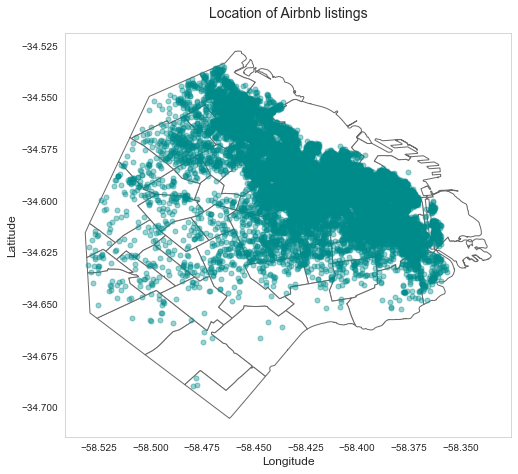

In [32]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
neighbourhoods.plot(ax=ax, color='white', edgecolor='dimgrey')
airbnb_geo.plot(ax=ax, marker='o', color='darkcyan', markersize=25,  alpha=0.4)
plt.title('Location of Airbnb listings', fontsize=14, pad=15)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid()
plt.show()

### 1.3 Metro stations dataset

Reading the metro stations dataset. Locally the metro is called the 'subte'.

In [33]:
subtes = pd.read_csv('estaciones-de-subte.csv', encoding='utf8')

I will create a Shapely Point object for each metro station, a geometric object that Geopandas can read. After I will create a GeoDataFrame out of the metro stations dataframe.

In [34]:
points_subtes = subtes.apply(lambda row: Point(row.long, row.lat), axis=1)
subtes_geo = gpd.GeoDataFrame(subtes, geometry=points_subtes)
subtes_geo.crs = 'epsg:3857'

Below I will plot the points of the metro stations together with the neighbourhood coordinates to check if everything went well.

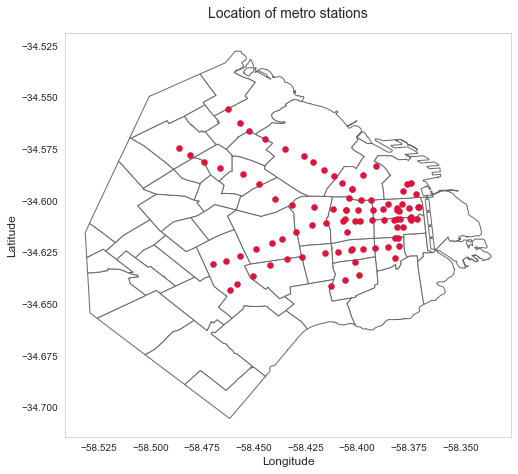

In [35]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
neighbourhoods.plot(ax=ax, color='white', edgecolor='dimgrey')
subtes_geo.plot(ax=ax, marker='o', color='crimson', markersize=30,  alpha=1)
plt.title('Location of metro stations', fontsize=14, pad=15)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid()
plt.show()

## 2. Feature Engineering

I would like to differentiate between two general property types: *houses* and *apartments*. This will allow me to easily compare the property types in the Airbnb dataset with the property types in the Properati dataset.

In [36]:
airbnb.property_type.unique()

array(['Condominium', 'Apartment', 'Loft', 'House', 'Guest suite',
       'Townhouse', 'Villa', 'Tiny house', 'Casa particular (Cuba)'],
      dtype=object)

In [37]:
houses = ['House', 'Townhouse', 'Villa', 'Tiny house']
apartments = ['Condominium', 'Apartment', 'Loft']

airbnb['property_type_general'] = np.nan
airbnb.loc[airbnb['property_type'].isin(houses), 'property_type_general'] = 'House'
airbnb.loc[airbnb['property_type'].isin(apartments), 'property_type_general'] = 'Apartment'

I remove the few rows where the general property type is unknown.

In [38]:
airbnb.drop(labels=airbnb[airbnb.property_type_general.isnull()].index, inplace=True)

Having an entire house to yourself is probably not the same as having an entire aparment to yourself. For example, I expect these to accomodate different amount of guests and have different price levels. Therefore, I will create a new column that combines the general property type with the room type column.

In [39]:
airbnb.room_type.unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

In [40]:
airbnb['property_and_room_type'] = np.nan

airbnb.loc[(airbnb['property_type_general']=='House')&(airbnb['room_type']=='Entire home/apt'),\
          'property_and_room_type'] = 'House - Entire home/apt'

airbnb.loc[(airbnb['property_type_general']=='House')&(airbnb['room_type']=='Private room'),\
          'property_and_room_type'] = 'House - Private room'

airbnb.loc[(airbnb['property_type_general']=='House')&(airbnb['room_type']=='Shared room'),\
          'property_and_room_type'] = 'House - Shared room'

airbnb.loc[(airbnb['property_type_general']=='Apartment')&(airbnb['room_type']=='Entire home/apt'),\
          'property_and_room_type'] = 'Apartment - Entire home/apt'

airbnb.loc[(airbnb['property_type_general']=='Apartment')&(airbnb['room_type']=='Private room'),\
          'property_and_room_type'] = 'Apartment - Private room'

airbnb.loc[(airbnb['property_type_general']=='Apartment')&(airbnb['room_type']=='Shared room'),\
          'property_and_room_type'] = 'Apartment - Shared room'

I will impute the missing values of the bathrooms, bedrooms and beds columns by the mean of the same property and room type.

In [41]:
airbnb['bathrooms'] = airbnb.groupby('property_and_room_type')['bathrooms'].transform(lambda x: x.fillna(x.mean()))
airbnb['bedrooms'] = airbnb.groupby('property_and_room_type')['bedrooms'].transform(lambda x: x.fillna(x.mean()))
airbnb['beds'] = airbnb.groupby('property_and_room_type')['beds'].transform(lambda x: x.fillna(x.mean()))

I will create dummy variables based on different amenities found in the amenities column.

In [43]:
amenities = {'tv':['TV'], 'wifi': ['Wifi', 'Internet'], 'air_conditioning': ['Air conditioning'], 'heating': ['Heating'],
             'hot_water': ['Hot water'], 'kitchen' : ['Kitchen'], 'refrigerator': ['Refrigerator'], 'breakfast': ['Breakfast'],
             'pool': ['Pool'], 'parking': ['Paid parking off premises', 'Free street parking', 'Paid parking on premises'],
             'elevator': ['Elevator'], 'gym': ['Gym'], 'private_entrance': ['Private entrance'], 'balcony/patio':
             ['Patio or balcony'], 'garden': ['Garden or backyard'], 'bbq': ['BBQ grill']}

def create_dummies(dic, col):
    for key, value in dic.items():
        words = ''
        for x in value:
            words += str(x) + '|'
        words = words[:-1]
        pattern = r'(' + str(words) +')'
        
        regex = re.compile(pattern, flags= re.IGNORECASE)
        airbnb[key] = airbnb[col].str.extract(regex, expand = True)
        airbnb[key] = airbnb[key].where(airbnb[key].isnull(), 1).fillna(0).astype(int)

create_dummies(amenities,'amenities')

I will create some additional features differentiating between high and low availability in 30, 60, 90 and 365 days.

In [44]:
airbnb['high_avaibility_30'] = [1 if x>20 else 0 for x in airbnb['availability_30']]
airbnb['low_avaibility_30'] = [1 if x<5 else 0 for x in airbnb['availability_30']]

airbnb['high_avaibility_60'] = [1 if x>50 else 0 for x in airbnb['availability_60']]
airbnb['low_avaibility_60'] = [1 if x<10 else 0 for x in airbnb['availability_60']]

airbnb['high_avaibility_90'] = [1 if x>80 else 0 for x in airbnb['availability_90']]
airbnb['low_avaibility_90'] = [1 if x<10 else 0 for x in airbnb['availability_90']]

airbnb['high_avaibility_365'] = [1 if x>300 else 0 for x in airbnb['availability_365']]
airbnb['low_avaibility_365'] = [1 if x<30 else 0 for x in airbnb['availability_365']]

I will add a feature with the minimum distance to any metro station, and another feature with the minimum distance to a station of metro line D (this is the metro line that is best connected with most tourist attractions). To calculate the distance between the airbnb listings and the metro stations, I will use the haversine function.

In [45]:
# source: https://gist.github.com/DeanThompson/d5d745eca4e9023c6501

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [46]:
airbnb['min_dist_to_subte'] = np.zeros((airbnb.shape[0]))

for index_airbnb, id_airbnb in enumerate(airbnb.id):
    distances = []
    for index_subte, id_subte in enumerate(subtes.id):
        distances.append(haversine(airbnb.longitude.iloc[index_airbnb],\
                                   airbnb.latitude.iloc[index_airbnb],\
                                   subtes.long.iloc[index_subte],\
                                   subtes.lat.iloc[index_subte]))
    min_distance = min(distances)
    airbnb.loc[airbnb.id==id_airbnb, 'min_dist_to_subte'] = min_distance

In [47]:
subte_D = subtes[subtes.linea=='D'].copy()

airbnb['min_dist_to_subteD'] = np.zeros((airbnb.shape[0]))

for index_airbnb, id_airbnb in enumerate(airbnb.id):
    distances = []
    for index_subte, id_subte in enumerate(subte_D.id):
        distances.append(haversine(airbnb.longitude.iloc[index_airbnb],\
                                   airbnb.latitude.iloc[index_airbnb],\
                                   subte_D.long.iloc[index_subte],\
                                   subte_D.lat.iloc[index_subte]))
    min_distance = min(distances)
    airbnb.loc[airbnb.id==id_airbnb, 'min_dist_to_subteD'] = min_distance

Finally I will create dummies for the *neighbourhood*, *property type* and *room type* columns.

In [48]:
dummies = pd.get_dummies(airbnb[['neighbourhood', 'property_type_general', 'room_type']], prefix='',\
                         prefix_sep='', drop_first=True)

In [49]:
airbnb = pd.concat([airbnb, dummies], axis=1)

## 3. Data exploration

The figure below shows the distribution of the Airbnb price per night in dollars for *houses* and for *apartments*. We can see that houses tend to have a lower price than apartments and the mayority of the airbnb prices for houses seem to lie somewhere between 10-35 dollars per night. The price for apartments varies more. The proportion of apartments with prices higher than 35 dollars is much bigger than those of houses.

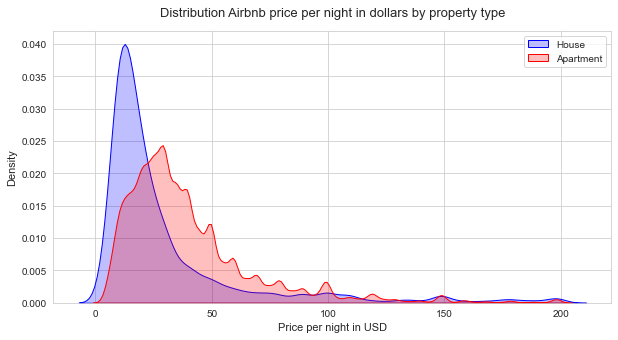

In [50]:
plt.figure(figsize=(10,5))
sns.kdeplot(airbnb[airbnb.property_type_general=='House'].price_usd, shade=True, color='blue', label='House', 
            bw_adjust=0.5)
sns.kdeplot(airbnb[airbnb.property_type_general=='Apartment'].price_usd, shade=True, color='red', label='Apartment',
            bw_adjust=0.5)
plt.title('Distribution Airbnb price per night in dollars by property type', fontsize=13, pad=15)
plt.xlabel('Price per night in USD', fontsize=11)
plt.ylabel('Density', fontsize=11)
plt.legend()

plt.show()

The figure below shows the distribution of the Airbnb price per night in dollars for the different room types. We can clearly see that entire houses/apartments have higher prices than shared and private rooms. 

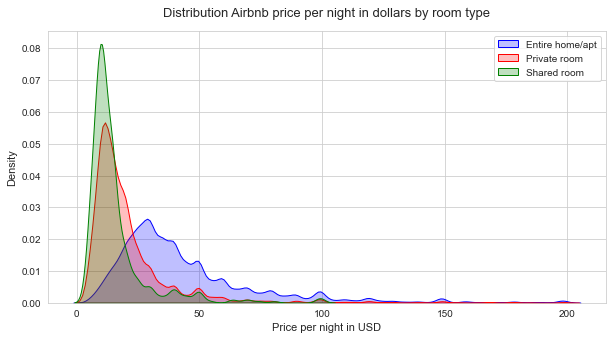

In [51]:
plt.figure(figsize=(10,5))
sns.kdeplot(airbnb[airbnb.room_type=='Entire home/apt'].price_usd, shade=True, color='blue', label='Entire home/apt', 
            bw_adjust=0.5)
sns.kdeplot(airbnb[airbnb.room_type=='Private room'].price_usd, shade=True, color='red', label='Private room', 
            bw_adjust=0.5)
sns.kdeplot(airbnb[airbnb.room_type=='Shared room'].price_usd, shade=True, color='green', label='Shared room', 
            bw_adjust=0.5)
plt.title('Distribution Airbnb price per night in dollars by room type', fontsize=13, pad=15)
plt.xlabel('Price per night in USD', fontsize=11)
plt.ylabel('Density', fontsize=11)
plt.legend()

plt.show()

Finally I will explore the same distributions by room type for apartments and houses separately. Again, we can cleary see that entire houses/apartments have higher prices than private or shared rooms. In case of entire houses, the prices vary even more than for entire apartments. This makes sense intuitively: entire houses/aparments probably have a bigger surface and can host more guests than private or shared rooms. Entire houses are more likely to have a bigger surface and host more guests than an entire apartment.

In [52]:
airbnb.property_and_room_type.value_counts()

Apartment - Entire home/apt    17412
Apartment - Private room        2950
House - Private room            1086
House - Entire home/apt          363
Apartment - Shared room          268
House - Shared room              148
Name: property_and_room_type, dtype: int64

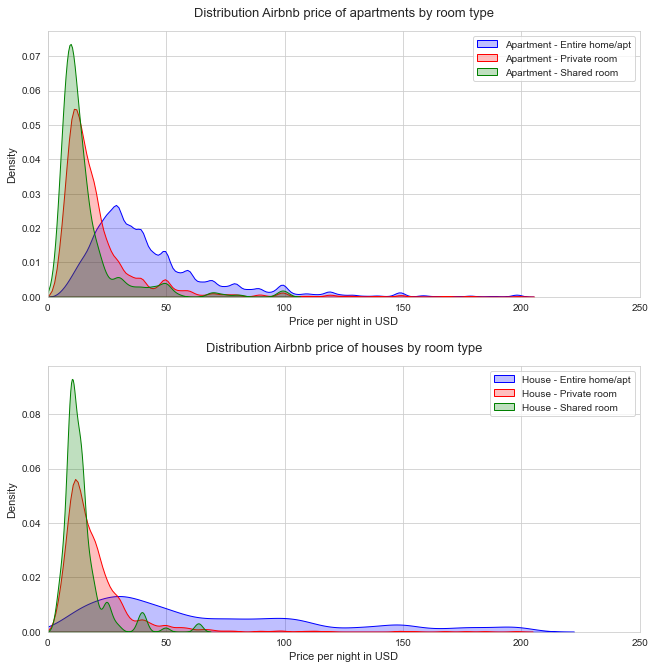

In [53]:
f, axes = plt.subplots(2, 1, figsize=(10,10))
f.tight_layout(pad=5)

ax1 = plt.subplot(211)

sns.kdeplot(airbnb[airbnb.property_and_room_type=='Apartment - Entire home/apt'].price_usd, 
            shade=True, color='blue', label='Apartment - Entire home/apt', ax=ax1, bw_adjust=0.5)
sns.kdeplot(airbnb[airbnb.property_and_room_type=='Apartment - Private room'].price_usd, 
            shade=True, color='red', label='Apartment - Private room', ax=ax1, bw_adjust=0.5)
sns.kdeplot(airbnb[airbnb.property_and_room_type=='Apartment - Shared room'].price_usd, 
            shade=True, color='green', label='Apartment - Shared room', ax=ax1, bw_adjust=0.5)

plt.title('Distribution Airbnb price of apartments by room type', fontsize=13, pad=15)
plt.xlabel('Price per night in USD', fontsize=11)
plt.ylabel('Density', fontsize=11)
plt.legend()
ax1.set_xlim([0, 250])

ax2 = plt.subplot(212)

sns.kdeplot(airbnb[airbnb.property_and_room_type=='House - Entire home/apt'].price_usd, 
            shade=True, color='blue', label='House - Entire home/apt', ax=ax2, bw_adjust=0.5)
sns.kdeplot(airbnb[airbnb.property_and_room_type=='House - Private room'].price_usd, 
            shade=True, color='red', label='House - Private room', ax=ax2, bw_adjust=0.5)
sns.kdeplot(airbnb[airbnb.property_and_room_type=='House - Shared room'].price_usd, 
            shade=True, color='green', label='House - Shared room', ax=ax2, bw_adjust=0.5)

plt.title('Distribution Airbnb price of houses by room type', fontsize=13, pad=15)
plt.xlabel('Price per night in USD', fontsize=11)
plt.ylabel('Density', fontsize=11)
plt.legend()
ax2.set_xlim([0, 250])

plt.show()

The figure below explores the differences in price per neighbourhood. The graph on the left shows the average price per neighbourhood and the graph on the right shows the price distribution per neighbourhood. Both are sorted from the largest average price to the lowest.

These graphs show some surprises. There are a couple of neighbourhoods that I didn't expect to have such high prices, for example: Villa Soldati, Versalles and Nueva Pompeya. There are also various neighbourhoods with large errorbars. Further analysis shows that these neighbourhoods have only a few airbnb listings. It is likely that these few listings are not representative for the whole neighbourhood.

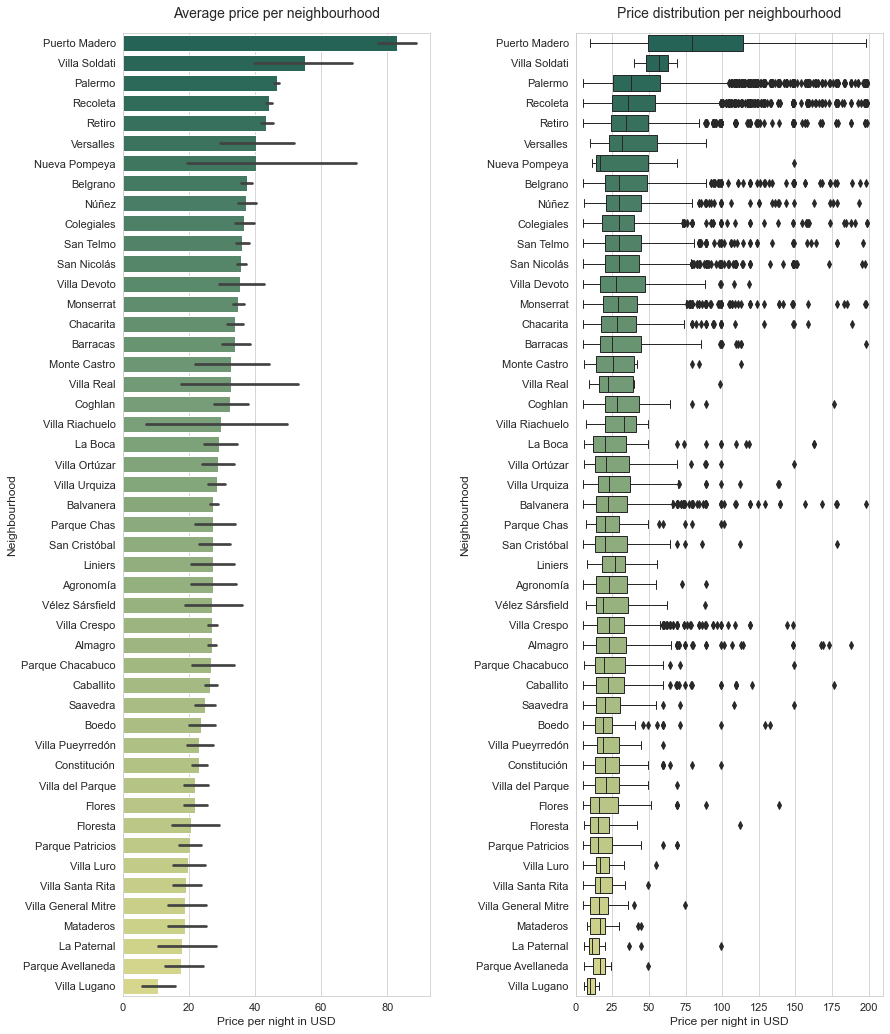

In [54]:
ranks = airbnb.groupby("neighbourhood")["price_usd"].mean().sort_values(ascending=False).index

f = plt.figure(figsize=(13, 15))

ax1 = plt.subplot(121)
sns.barplot(x=airbnb.price_usd, y=airbnb.neighbourhood, palette='summer', saturation=0.5, ax=ax1, order=ranks)
plt.title('Average price per neighbourhood', fontsize=14, pad=15)
plt.xlabel('Price per night in USD', fontsize=12)
plt.ylabel('Neighbourhood', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

ax2 = plt.subplot(122)
sns.boxplot(x=airbnb.price_usd, y=airbnb.neighbourhood, palette='summer', saturation=0.5, ax=ax2, order=ranks,
           linewidth=1)
plt.title('Price distribution per neighbourhood', fontsize=14, pad=15)
plt.xlabel('Price per night in USD', fontsize=12)
plt.ylabel('Neighbourhood', fontsize=12)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
ax2.set_xlim([0, 210])

f.tight_layout(pad=3)

plt.show()

In [55]:
airbnb.neighbourhood.value_counts()

Palermo                6805
Recoleta               3675
San Nicolás            1335
Retiro                 1115
Balvanera              1094
Belgrano               1057
Almagro                 942
Monserrat               904
San Telmo               773
Villa Crespo            735
Colegiales              444
Núñez                   442
Caballito               432
Chacarita               390
Villa Urquiza           228
Puerto Madero           225
Barracas                157
Constitución            150
Saavedra                128
La Boca                 126
San Cristóbal           112
Boedo                   105
Flores                  103
Villa Ortúzar            89
Coghlan                  82
Parque Patricios         66
Villa Devoto             55
Villa del Parque         51
Parque Chacabuco         50
Parque Chas              49
Villa Pueyrredón         34
Agronomía                30
Floresta                 29
Villa General Mitre      25
Villa Santa Rita         22
Vélez Sársfield     

I will drop the rows from neighbourhoods with only a few airbnb listings. I will also delete the columns with dummy variables for these neighbourhoods.

In [56]:
neigbourhoods_to_drop = ['Villa Riachuelo', 'Villa Soldati', 'Villa Lugano', 'Villa Real', 'Nueva Pompeya',
                         'Parque Avellaneda', 'Mataderos', 'Versalles', 'Liniers', 'Villa Luro', 'Vélez Sársfield',
                         'Monte Castro', 'La Paternal', 'Villa Santa Rita', 'Villa General Mitre', 'Floresta', 
                         'Agronomía', 'Villa Pueyrredón']

airbnb.drop(labels=airbnb[airbnb.neighbourhood.isin(neigbourhoods_to_drop)].index, inplace=True)

neigbourhoods_to_drop.remove('Agronomía')

airbnb.drop(columns=neigbourhoods_to_drop, inplace=True)

I am interested in seeing the propertion of property types per neighboorhood, to see if there are any significant differences. To do so I will create a dataframe with the count of apartments and houses per neighbourhood. After I will change these counts into percentages with the help of a total column.

In [57]:
# Group the properties by neighbourhood and property type and apply 'count'
prop_types_nbh = airbnb[['id', 'property_type_general', 'neighbourhood']].\
                                        groupby(['neighbourhood', 'property_type_general']).count().reset_index()

# Use 'pivot' to move the property types to columns
prop_types_nbh = prop_types_nbh.pivot(index='neighbourhood', columns='property_type_general',\
                                                                  values='id')
# Fill any missing values with 0
prop_types_nbh = prop_types_nbh.fillna(0)

# Create a total column
prop_types_nbh['total'] = prop_types_nbh['Apartment'] + prop_types_nbh['House']

# Calculate the percentages
prop_types_nbh['Apartment'] = prop_types_nbh['Apartment']/prop_types_nbh['total']
prop_types_nbh['House'] = prop_types_nbh['House']/prop_types_nbh['total']

In [58]:
prop_types_nbh.head()

property_type_general,Apartment,House,total
neighbourhood,,,
Almagro,0.883227,0.116773,942
Balvanera,0.928702,0.071298,1094
Barracas,0.783439,0.216561,157
Belgrano,0.959319,0.040681,1057
Boedo,0.685714,0.314286,105


In the figure below we can see that there are a couple of neighbourhoods with almost no houses on Airbnb, like Retiro, Puerto Madero and San Nicolás. These are all neighbourhoods in the north-east of the city.

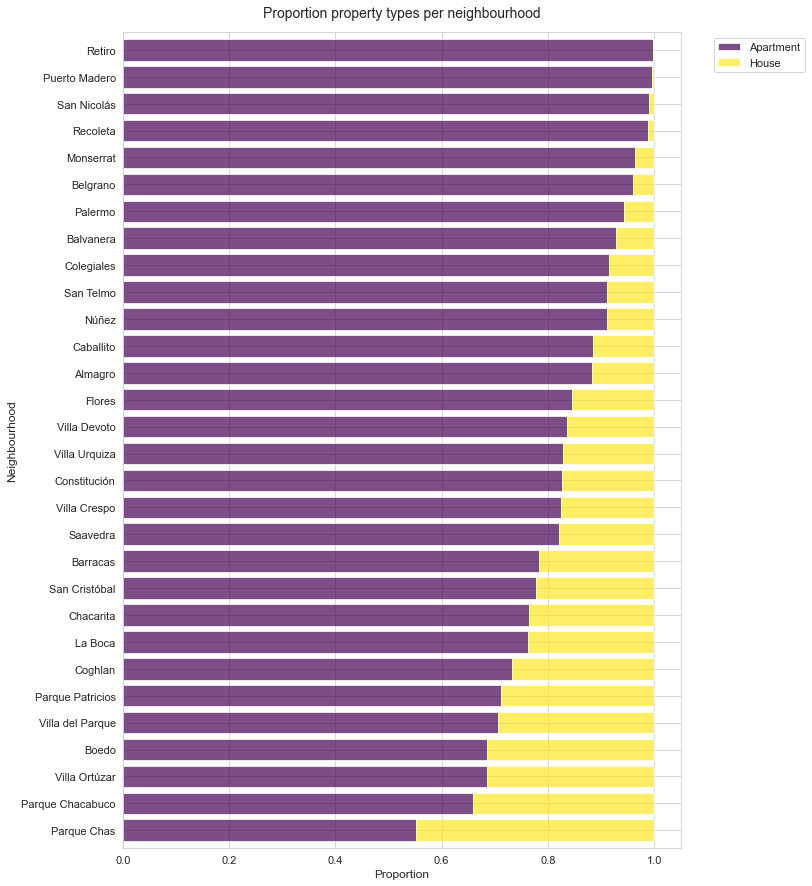

In [59]:
colors = plt.cm.viridis(np.linspace(0, 1, 2))

prop_types_nbh.drop(columns=['total']).sort_values(by='Apartment').plot(kind='barh', stacked=True, width=0.8, 
                                                                        figsize=(10,15), color=colors, alpha=0.7)
plt.title('Proportion property types per neighbourhood', fontsize=14, pad=15)
plt.xlabel('Proportion', fontsize=12)
plt.ylabel('Neighbourhood', fontsize=12)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
plt.legend(bbox_to_anchor=(1.05, 1), fontsize=11)

I will do the same for the room types per neighbourhood.

In [61]:
# Group the properties by neighbourhood and room type and apply 'count'
room_types_nbh = airbnb[['id', 'room_type', 'neighbourhood']].\
                                        groupby(['neighbourhood', 'room_type']).count().reset_index()

# Use 'pivot' to move the room types to columns
room_types_nbh = room_types_nbh.pivot(index='neighbourhood', columns='room_type',\
                                                                  values='id')
# Fill any missing values with 0
room_types_nbh = room_types_nbh.fillna(0)

# Create a total column
room_types_nbh['total'] = room_types_nbh['Entire home/apt'] + room_types_nbh['Private room'] + room_types_nbh['Shared room']

# Calculate the percentages
room_types_nbh['Entire home/apt'] = room_types_nbh['Entire home/apt']/room_types_nbh['total']
room_types_nbh['Private room'] = room_types_nbh['Private room']/room_types_nbh['total']
room_types_nbh['Shared room'] = room_types_nbh['Shared room']/room_types_nbh['total']

The neighbourhoods with the biggest proportion of entire homes/apartments are also neighbourhoods with a relatively high average price. This makes sense since we saw earlier that the room type 'Entire home/apt' has higher prices than private or shared rooms.

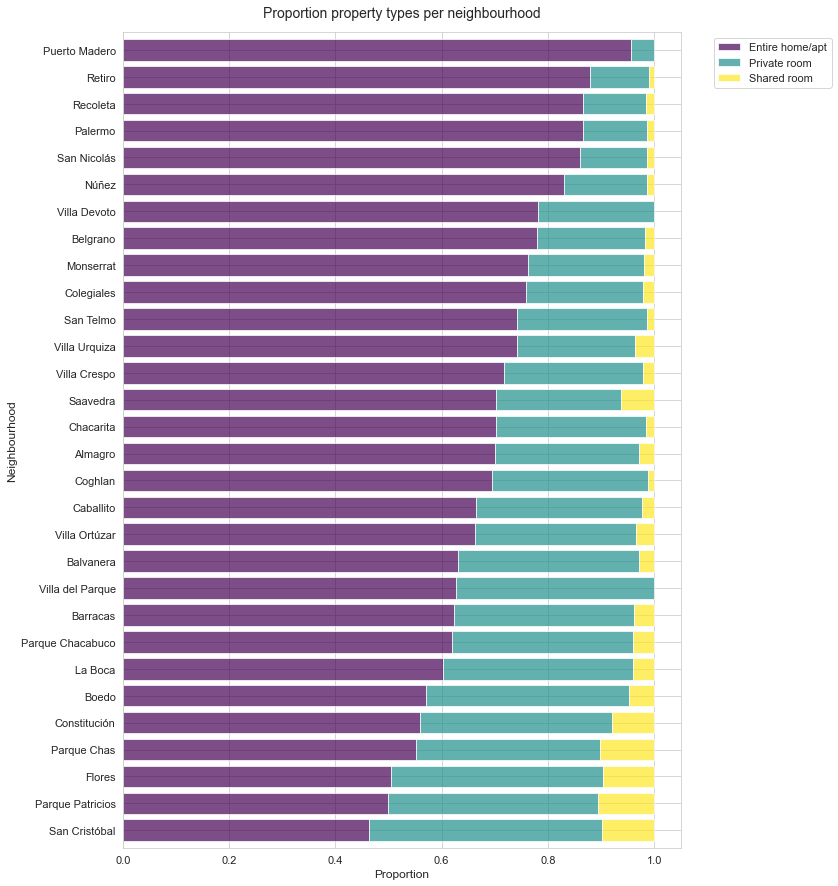

In [62]:
colors = plt.cm.viridis(np.linspace(0, 1, 3))

room_types_nbh.drop(columns=['total']).sort_values(by='Entire home/apt').plot(kind='barh', stacked=True, width=0.8, 
                                                                        figsize=(10,15), color=colors, alpha=0.7)
plt.title('Proportion property types per neighbourhood', fontsize=14, pad=15)
plt.xlabel('Proportion', fontsize=12)
plt.ylabel('Neighbourhood', fontsize=12)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
plt.legend(bbox_to_anchor=(1.05, 1), fontsize=11)

Finally I'll do the same analysis distinguishing both property and room types.

In [63]:
# Group the properties by neighbourhood, property and room type and apply 'count'
prop_room_types_nbh = airbnb[['id', 'property_and_room_type', 'neighbourhood']].\
                                        groupby(['neighbourhood', 'property_and_room_type']).count().reset_index()

# Use 'pivot' to move the property and room types to columns
prop_room_types_nbh = prop_room_types_nbh.pivot(index='neighbourhood', columns='property_and_room_type',\
                                                                  values='id')
# Fill any missing values with 0
prop_room_types_nbh = prop_room_types_nbh.fillna(0)

# Create a total column
prop_room_types_nbh['total'] = prop_room_types_nbh['Apartment - Entire home/apt'] + prop_room_types_nbh['Apartment - Private room']\
                        + prop_room_types_nbh['Apartment - Shared room'] + prop_room_types_nbh['House - Entire home/apt']\
                        + prop_room_types_nbh['House - Private room'] + prop_room_types_nbh['House - Shared room']

# Calculate the percentages
prop_room_types_nbh['Apartment - Entire home/apt'] = prop_room_types_nbh['Apartment - Entire home/apt']/prop_room_types_nbh['total']
prop_room_types_nbh['Apartment - Private room'] = prop_room_types_nbh['Apartment - Private room']/prop_room_types_nbh['total']
prop_room_types_nbh['Apartment - Shared room'] = prop_room_types_nbh['Apartment - Shared room']/prop_room_types_nbh['total']
prop_room_types_nbh['House - Entire home/apt'] = prop_room_types_nbh['House - Entire home/apt']/prop_room_types_nbh['total']
prop_room_types_nbh['House - Private room'] = prop_room_types_nbh['House - Private room']/prop_room_types_nbh['total']
prop_room_types_nbh['House - Shared room'] = prop_room_types_nbh['House - Shared room']/prop_room_types_nbh['total']

We can see that most of the apartments being rented on Airbnb are entire apartments. Most of the houses on Airbnb are private rooms though. This does not seem to depend on the neighbourhood.

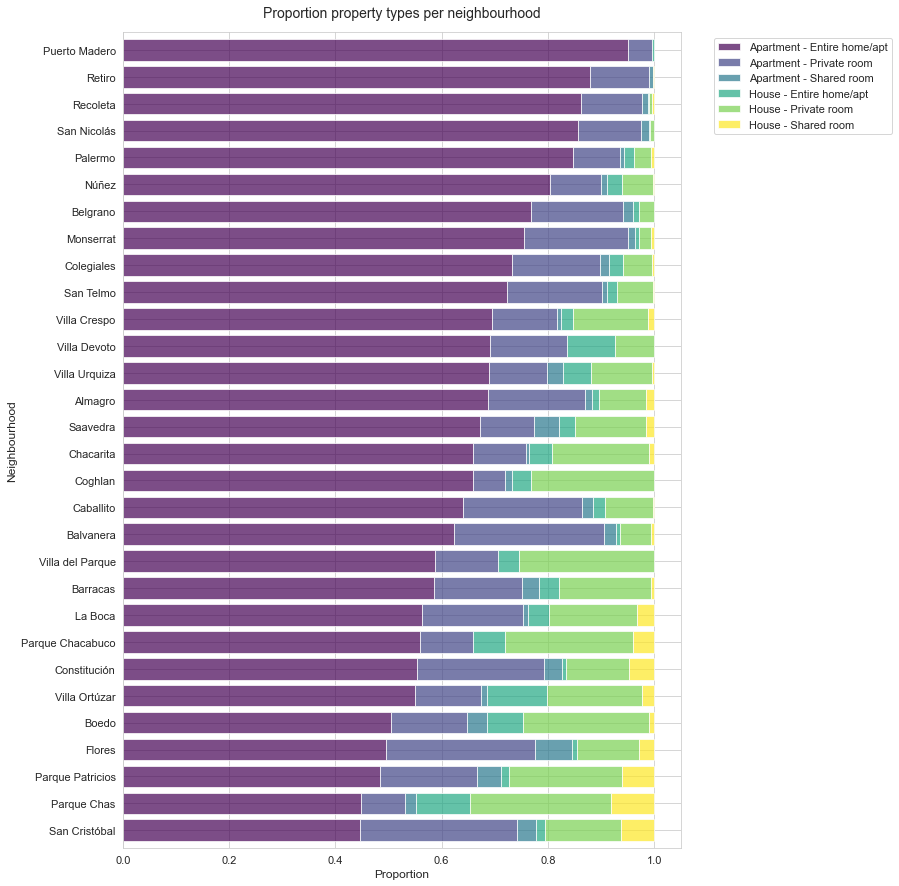

In [64]:
colors = plt.cm.viridis(np.linspace(0, 1, 6))

prop_room_types_nbh.drop(columns=['total']).sort_values(by='Apartment - Entire home/apt').plot(kind='barh',
                                                                                               stacked=True, width=0.8, 
                                                                                               figsize=(10,15), 
                                                                                               color=colors, alpha=0.7)
plt.title('Proportion property types per neighbourhood', fontsize=14, pad=15)
plt.xlabel('Proportion', fontsize=12)
plt.ylabel('Neighbourhood', fontsize=12)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
plt.legend(bbox_to_anchor=(1.05, 1), fontsize=11)

The figure below shows the average reviews per month per neighbourhood. Assuming that more frequently booked properties will have more reviews, we can use the amount of reviews as an indicator of how often the property is booked. The neighbourhoods on the left, with the highest amount of reviews per month, are also the neighbourhoods with most tourist attractions, restaurants and bars.

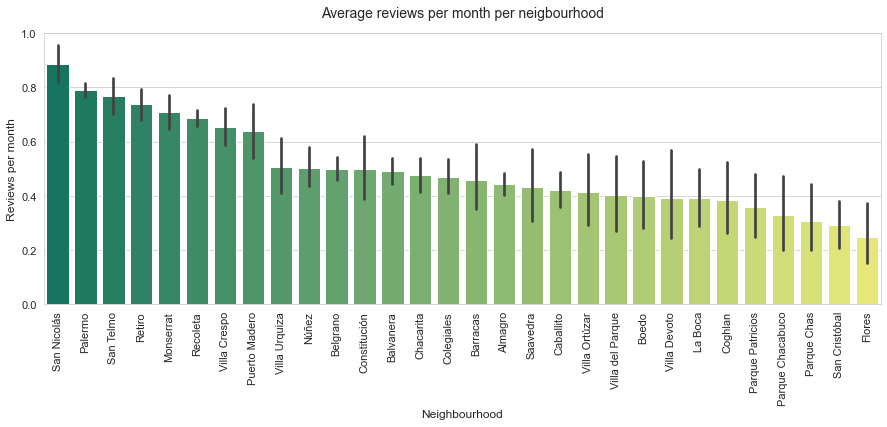

In [65]:
ranks = airbnb.groupby("neighbourhood")["reviews_per_month"].mean().sort_values(ascending=False).index

f = plt.figure(figsize=(15, 5))

sns.barplot(x=airbnb.neighbourhood, y=airbnb.reviews_per_month, order=ranks, palette='summer')
plt.title('Average reviews per month per neigbourhood', fontsize=14, pad=15)
plt.xlabel('Neighbourhood', fontsize=12)
plt.ylabel('Reviews per month', fontsize=12)
plt.xticks(rotation=90, fontsize=11)
plt.yticks(fontsize=11)

plt.show()

The figure below compares the amount of guests each property and room type can accomodate. Confirming an earlier assumption, the figure shows that entire homes/apartments can accomodate more guests than private and shared rooms. The amount of guests to accomodate is especially much higher for entire houses. This is probably the reason that these room types have higher prices.

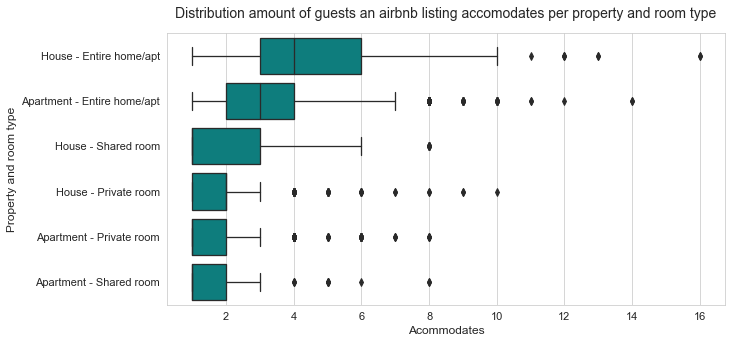

In [66]:
ranks = airbnb.groupby("property_and_room_type")["accommodates"].mean().sort_values(ascending=False).index

f = plt.figure(figsize=(10, 5))

sns.boxplot(x=airbnb.accommodates, y=airbnb.property_and_room_type, order=ranks, color='darkcyan', saturation=0.8,
            linewidth=1.3)
plt.title('Distribution amount of guests an airbnb listing accomodates per property and room type', fontsize=14, pad=15)
plt.xlabel('Acommodates', fontsize=12)
plt.ylabel('Property and room type', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.show()

The figure below explores the availability variables. The availability in 30, 60 and 90 days all show two strong peaks in their distributions: properties with very low or no availability and properties with very high availability. The distribution of the availability in 365 days shows 4 peaks: properties with very low or no availability and properties with very high availability, but also properties that are available a quarter of the year and properties that are available half of the year.

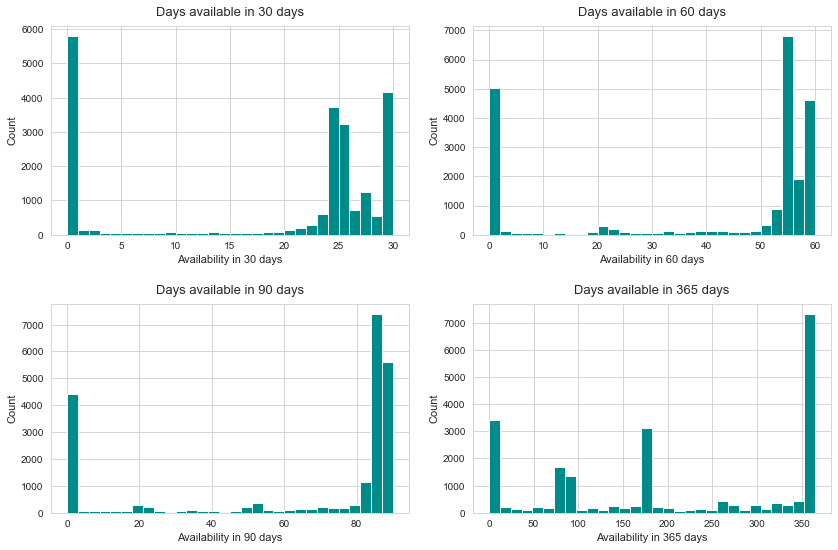

In [67]:
f, axes = plt.subplots(2, 1, figsize=(12,8))

ax1 = plt.subplot(221)
sns.histplot(airbnb.availability_30, ax=ax1, bins=30, color='darkcyan', alpha=1)
plt.title('Days available in 30 days', fontsize=13, pad=10)
plt.xlabel('Availability in 30 days', fontsize=11)
plt.ylabel('Count', fontsize=11)

ax2 = plt.subplot(222)
sns.histplot(airbnb.availability_60, ax=ax2, bins=30, color='darkcyan', alpha=1)
plt.title('Days available in 60 days', fontsize=13, pad=10)
plt.xlabel('Availability in 60 days', fontsize=11)
plt.ylabel('Count', fontsize=11)

ax3 = plt.subplot(223)
sns.histplot(airbnb.availability_90, ax=ax3, bins=30, color='darkcyan', alpha=1)
plt.title('Days available in 90 days', fontsize=13, pad=10)
plt.xlabel('Availability in 90 days', fontsize=11)
plt.ylabel('Count', fontsize=11)

ax4 = plt.subplot(224)
sns.histplot(airbnb.availability_365, ax=ax4, bins=30, color='darkcyan', alpha=1)
plt.title('Days available in 365 days', fontsize=13, pad=10)
plt.xlabel('Availability in 365 days', fontsize=11)
plt.ylabel('Count', fontsize=11)

f.tight_layout(pad=2)

plt.show()

Since I have changed many things to the airbnb dataset in the data cleaning and feature engingeering part, I will reload the GeoDataFrame created earlier, so that that all changes are also applied here.

In [68]:
airbnb_geo = gpd.GeoDataFrame(airbnb, geometry=points)
airbnb_geo.crs = 'epsg:3857'

I will create a new dataframe that combines the data of the neighbourhoods dataframe with the data of the airbnb geodataframe. After the data cleaning, there are a few neighbourhoods in the neighbourhood dataset that do not appear anymore in the airbnb dataset. I will remove these rows.

In [69]:
neighbourhood_and_airbnb = gpd.sjoin(neighbourhoods, airbnb_geo, how="left")
neighbourhood_and_airbnb.dropna(subset=['neighbourhood'], inplace=True)

I will calculate the average price per neighbourhood, so I can visualize this data in a choropleth map.

In [70]:
neighbourhood_and_airbnb['average_price_neighbourhood'] = neighbourhood_and_airbnb['price_usd'].groupby(
                                                          neighbourhood_and_airbnb['neighbourhood']).transform('mean')

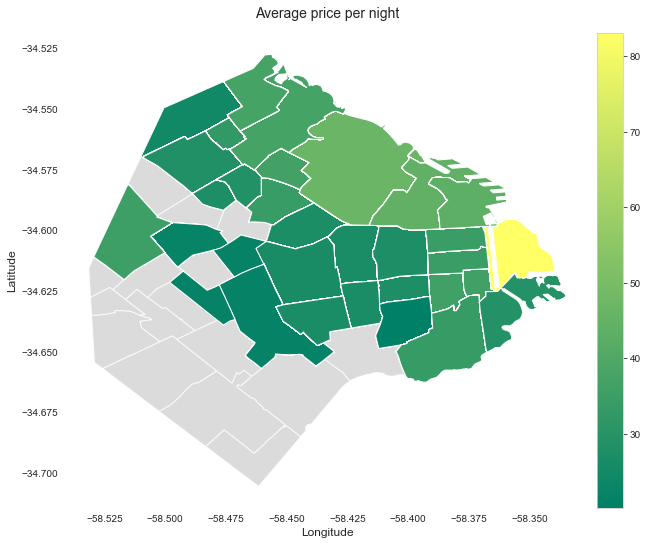

In [71]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(10,10))
neighbourhoods.plot(ax=ax, color='lightgrey', alpha=0.8)
plt.title('Average price per night', fontsize=14, pad=15)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid()
sns.despine(left=True, bottom=True)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
neighbourhood_and_airbnb.plot(column='average_price_neighbourhood', legend=True, ax=ax, cmap='summer', cax=cax)

plt.show()

Finally I save the final dataframe as a pickle.

In [72]:
with open('airbnb_clean.pkl', 'wb') as f_df:
    pickle.dump(airbnb, f_df)